In [83]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
import pylab as plt

%matplotlib inline



In [84]:
story_original = "Through history, most people didn't die of cancer or heart disease, the lifestyle diseases that are common in the Western world today. This is mostly because people didn't live long enough to develop them. They died of injuries -- being gored by an ox, shot on a battlefield, crushed in one of the new factories of the Industrial Revolution -- and most of the time from infection, which followed those injuries.\n\nThat changed when antibiotics were discovered. In 1928, Alexander Fleming discovered penicillin, a drug still used today to fight bacterial infections. Suddenly, infections that had been a death sentence became remedied within days. During World War II, this drug treated pneumonia and sepsis, and has been estimated to have saved between 12-15% of Allied Forces lives. We have been living inside the golden epoch of the miracle drugs, and now, we are coming to an end of it.\n\nPeople are dying of infections again because of a phenomenon called antibiotic resistance, or popularly referred to as “superbugs”. Bacteria compete against each other for resources, for food, by manufacturing lethal compounds that they direct against each other. When we first made antibiotics, we took those compounds into the lab and made our own versions of them, and bacteria responded to our attack the way they always had.\n\nFor 70 years, we played a game of leapfrog -- our drug and their resistance, and then another drug, and then resistance again -- and now the game is ending. Bacteria develop resistance so quickly that pharmaceutical companies have decided making antibiotics is not in their best interest, so there are infections moving across the world for which, out of the more than 100 antibiotics available on the market, two drugs might work with side effects, or one drug, or none.\n\nIt would be natural to hope that these infections are extraordinary cases, but in fact, in the United States and Europe, 50 thousand people a year die of infections which no drugs can help. A project chartered by the British government known as the Review on Antimicrobial Resistance estimates that the worldwide toll right now is 700 thousand deaths a year. Also, if we can't get this under control by 2050, the worldwide toll will be 10 million deaths a year (more than the current population of New York City).\n\nThe scale of antibiotic resistance seems overwhelming, but if you've ever bought a fluorescent light bulb because you were concerned about climate change, you already know what it feels like to take a tiny step to address an overwhelming problem. We could take those kinds of steps for antibiotic use too. We could forgo giving an antibiotic for our kids’ ear infection, if we're not sure it's the right one. And we could promise each other to never again to buy chicken or shrimp or fruit raised with routine antibiotic use. If we did those things, we could slow down the arrival of the post-antibiotic world."
cols = ["language","education","age","ideology","technical_issues","confusion","engagement","difficulty"] 

# General functions

In [109]:


def jaccard(strs):
    str1,str2 = strs
    if isinstance(str1,float) or isinstance(str2,float):
        return np.NaN
    str1 = set(str1.split())
    str2 = set(str2.split())
    return float(len(str1 & str2)) / len(str1 | str2)


def create_similarity(data):
    """
    Calculate Jaccard index with previous stories
    """
    #Add original story
    data["story_original"] = story_original
    
    for col in ["story1","story2","story_merged","story_original"]:
        data.loc[:,col] = data.loc[:,col].str.lower()
    
    
    #Similarity with story1
    data["jaccard_1"] = data[["story1","story_merged"]].apply(jaccard,axis=1)
    #Similarity with story2
    data["jaccard_2"] = data[["story2","story_merged"]].apply(jaccard,axis=1)
    #Average similarity with previous layer
    data["jaccard_previous_layer"] = data[["jaccard_1","jaccard_2"]].mean(1)
    #Similarity with story_original
    data["jaccard_original_story"] = data[["story_merged","story_original"]].apply(jaccard,axis=1)

    #Add layer 1
    data["layer_n"] += 1
    
    return data[["id","condition","layer_n","jaccard_previous_layer","jaccard_original_story"]+cols]

# Concatenating data

In [115]:
datas = []

for exp in os.listdir("data_cleaned"):
    data = pd.read_csv(f"data_cleaned/{exp}", sep="\t")
    data["id"] = exp
    if "chain" in exp:
        data["condition"] = "chain"
    else:
        data["condition"] = "network"
    datas.append(create_similarity(data))
    
results = pd.concat(datas)
results.head()

,id,condition,layer_n,jaccard_previous_layer,jaccard_original_story,language,education,age,ideology,technical_issues,confusion,engagement,difficulty
0,3layers_experiment_1.csv,network,1.0,0.198925,0.198925,Yes,6,1.0,2,No.,No.,8,4
1,3layers_experiment_1.csv,network,1.0,0.196970,0.196970,Yes,6,1.0,5,no,no,10,2
2,3layers_experiment_1.csv,network,2.0,0.170420,0.085987,Yes,5,2.0,5,No,No I di wonder if there should be a word count...,10,6
3,3layers_experiment_1.csv,network,2.0,0.172811,0.112150,Yes,7,2.0,6,none,no problems,5,6
4,3layers_experiment_1.csv,network,3.0,0.192341,0.074766,Yes,6,2.0,4,No,No,10,2


# Plot

In [111]:
def set_style(name):
    plt.xlabel("Layer number")
    plt.ylabel(f"Similarity with {name}")
    plt.grid("on")
    plt.rc('axes', linewidth=2)
    sns.despine()

/home/javiergb/Programs/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


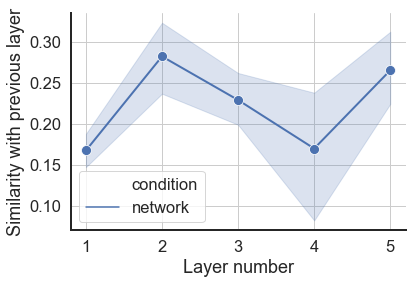

In [113]:
sns.lineplot(x="layer_n",y="jaccard_previous_layer",hue="condition",data=results,lw=2,marker="o",markersize=10)
set_style("previous layer")


/home/javiergb/Programs/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


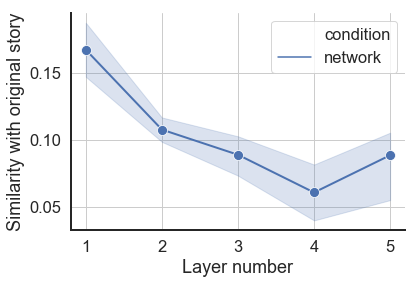

In [114]:
sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",data=results,lw=2,marker="o",markersize=10)
set_style("original story")